In today's dynamic business landscape, industries aim not only to attract new customers but also to retain their existing ones. Given the uniqueness of each customer, employing a one-size-fits-all approach is ineffective. Therefore, it is more effective for companies to categorize their customers based on their attributes and behaviours, aligning their marketing approaches closely with the characteristics of similar customer groups. The process of categorizing customers based on shared behaviour or attributes is called customer segmentation.
The objective of this project is to develop a customer segmentation model for a UK-based and registered non-store online retail business specializing in unique all-occasion gifts, with a significant portion of its customer base consisting of wholesalers. The model employs the RFM framework, assessing Recency, Frequency, and Monetary value as key indicators for analysing customer behaviour. These three dimensions aid in identifying distinct customer groups with similar characteristics.
The steps in this project include data cleaning, involving the identification of null values, erroneous entries, and cancelled items. The subsequent step is exploratory analysis, utilizing a word cloud to identify the most frequent words in the product descriptions, analysing money spent by countries, and plotting a time series for expenditure. The third step involves defining metrics such as frequency, recency, and monetary values. Finally, the project employs K-means clustering to group customers based on these metrics.

In [ ]:
from azureml.core import Workspace, Dataset

subscription_id = 'd65e1716-23f6-4fb9-9765-112bc97a3ba8'
resource_group = 'mie-1628'
workspace_name = 'OnlineRetail'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='customer-segmentation')
data_online= dataset.to_pandas_dataframe()
data_online.head(5)

In [40]:
# import Libraries

import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

In [2]:
! pip install wordcloud

### Dataset

In [3]:
data_online=pd.read_excel("Online Retail.xlsx")

In [4]:
print (data_online.info())
print (data_online.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
(541909, 8)


In [5]:
data_online.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The dataset comprises 541,909 records and includes 8 features. The data collection period spans from December 1, 2011, to December 9, 2012.The data structure is :
1- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
2- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
3- Description: Product (item) name. Nominal.
4- Quantity: The quantities of each product (item) per transaction. Numeric.	
5- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
6- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
8- Country: Country name. Nominal, the name of the country where each customer resides. 


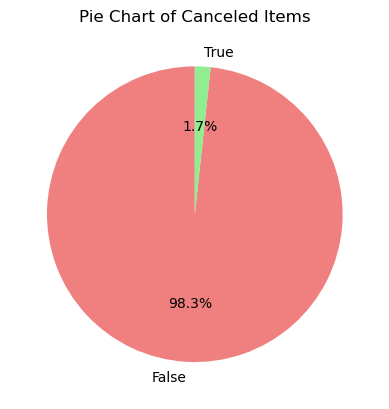

In [6]:
# InvoiceNO
data_online["Cancled"] = data_online['InvoiceNo'].str.contains('C', na=False)
canceled_counts = data_online['Cancled'].value_counts()
labels = canceled_counts.index
sizes = canceled_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('Pie Chart of Canceled Items')
plt.show()

The column "InvoiceNO" comprises a 6-digit integral number assigned uniquely to each transaction. If the code begins with the letter "C," it signifies a cancellation. The pie chart illustrates that 1.7% of the total purchases were canceled.

The column "StockCode" contains product codes, each uniquely assigned to a distinct product. The "Description" column displays the product names. The word cloud illustrates the most frequent words in the "Description" column.

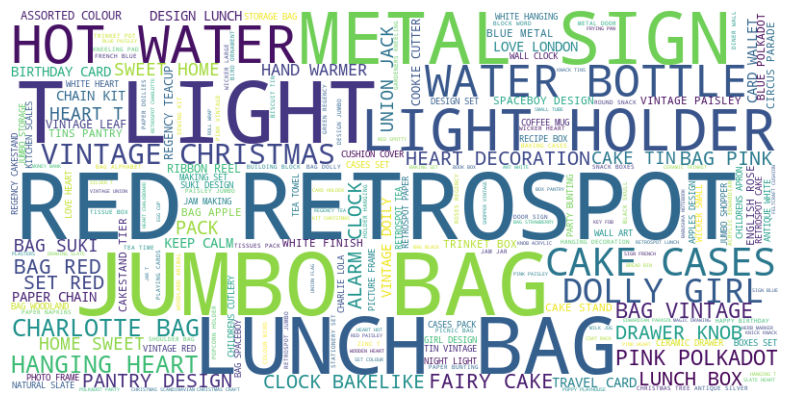

In [7]:
text = ' '.join(data_online['Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
data_online["Price"]=data_online["Quantity"] * data_online["UnitPrice"]
data_online["Price"].describe()

count    541909.000000
mean         17.987795
std         378.810824
min     -168469.600000
25%           3.400000
50%           9.750000
75%          17.400000
max      168469.600000
Name: Price, dtype: float64

In [9]:
first_date = data_online['InvoiceDate'].min()
last_date = data_online['InvoiceDate'].max()

print(f"First date: {first_date}")
print(f"Last date: {last_date}")

First date: 2010-12-01 08:26:00
Last date: 2011-12-09 12:50:00


The "Quantity" column represents the number of items purchased, "InvoiceDate" denotes the day and time of each transaction, and "UnitPrice" signifies the numeric product price per unit in sterling. The graphs below highlight specific instances where a substantial number of items were both purchased and cancelled on the same day.

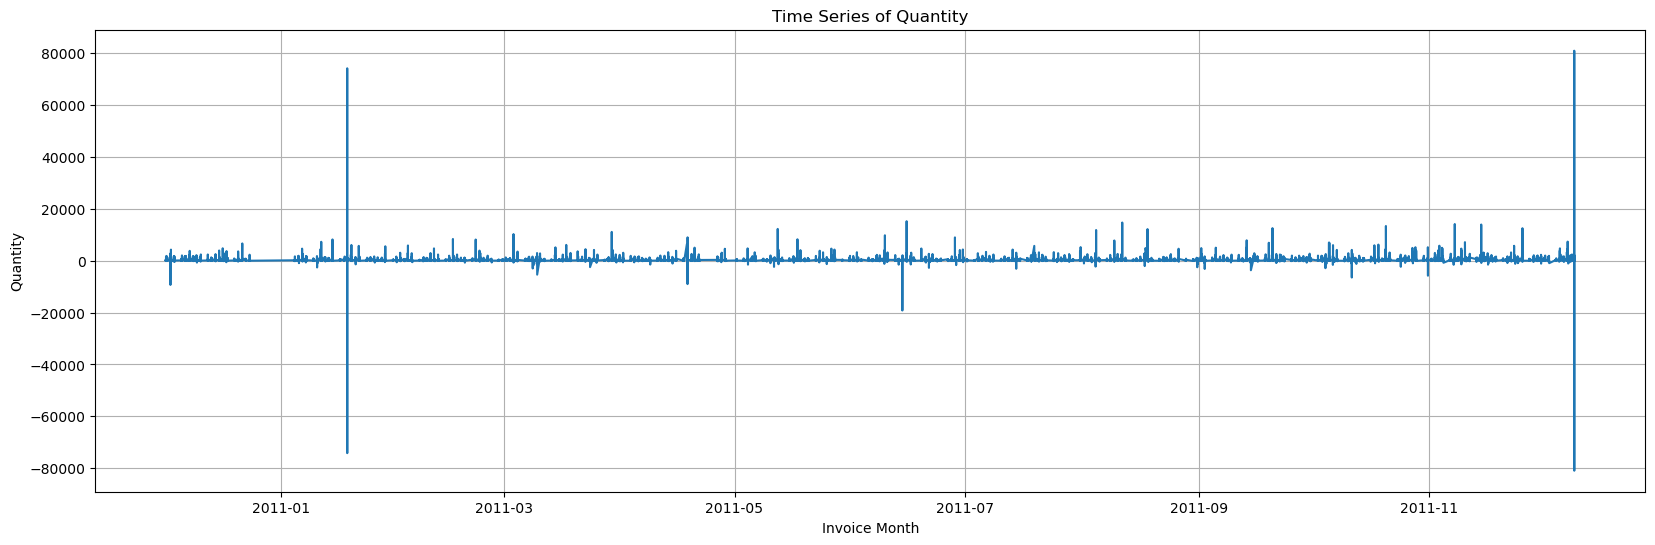

In [10]:
Quantity_Date = data_online.groupby('InvoiceDate')['Quantity'].sum()
plt.figure(figsize=(20, 6))
plt.plot(Quantity_Date.index, Quantity_Date.values, linestyle='-')
plt.title('Time Series of Quantity')
plt.xlabel('Invoice Month')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

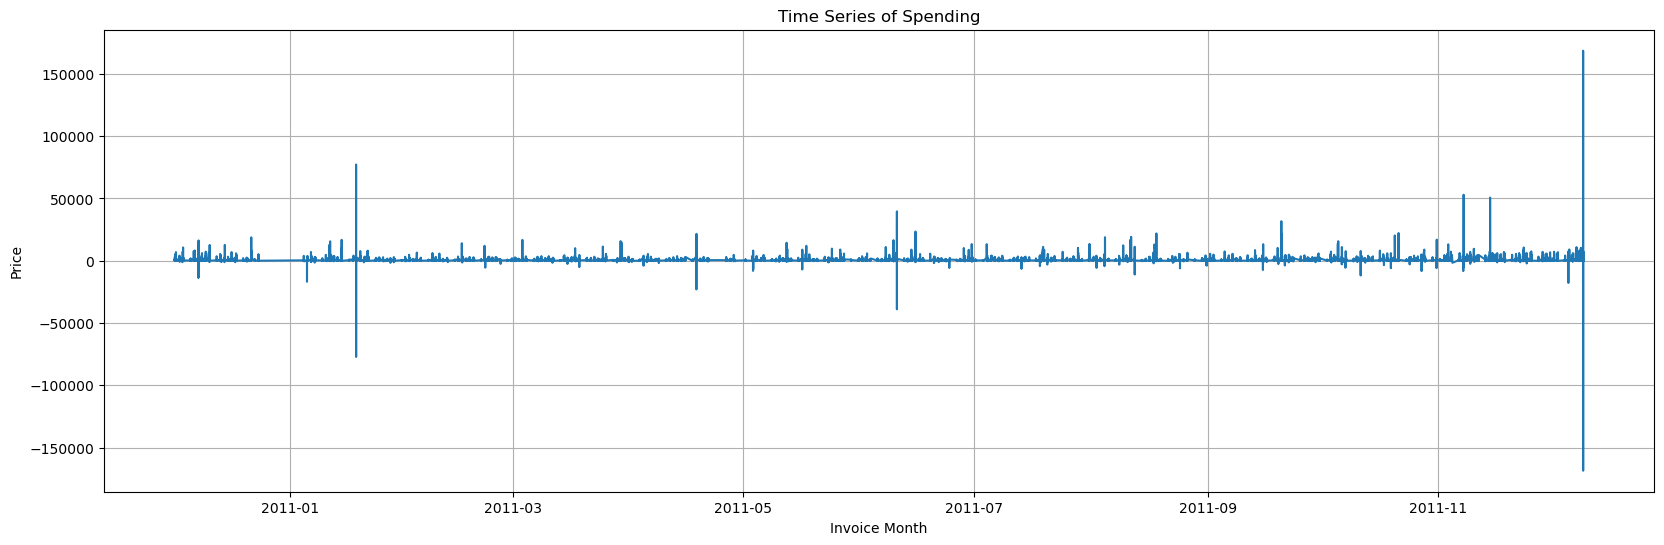

In [11]:
Quantity_Date = data_online.groupby('InvoiceDate')['Price'].sum()
plt.figure(figsize=(20, 6))
plt.plot(Quantity_Date.index, Quantity_Date.values, linestyle='-')
plt.title('Time Series of Spending')
plt.xlabel('Invoice Month')
plt.ylabel('Price')
plt.grid(True)
plt.show()

These unusual figures are depicted in the box plot below, revealing outliers within the data frame. Additionally, it is noteworthy that there are instances of negative quantities and zero prices for certain items.

<Axes: xlabel='UnitPrice', ylabel='Quantity'>

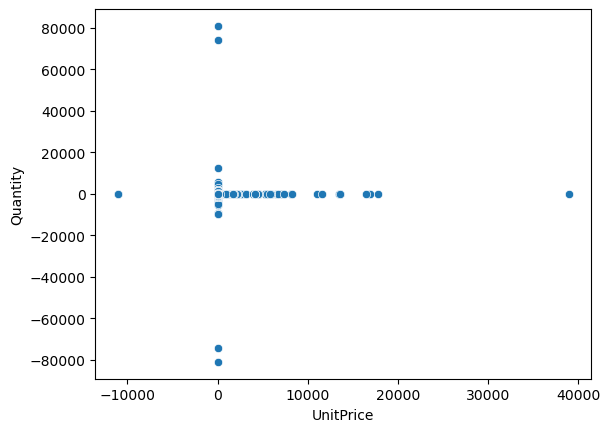

In [12]:
sns.scatterplot(x=data_online['UnitPrice'], y=data_online['Quantity'], data=data_online)

In [13]:
country_price_sum = data_online.groupby("Country")["Price"].sum()

In [14]:
Tablue_data = data_online.to_csv('data_retail.csv', index=False)

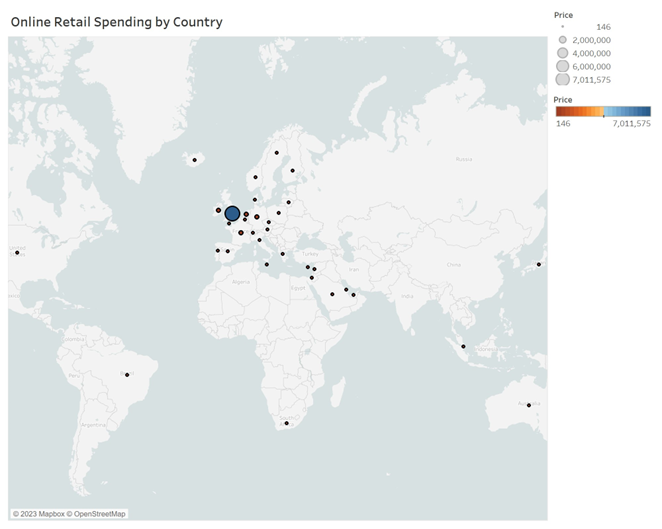


The "Country" column specifies the name of the country where each customer resides, while the "CustomerID" column consists of unique 5-digit integral numbers assigned to individual customers. The map illustrates that the highest amount of money was spent by customers in the UK.

### Data Cleaning 

After analysing the data frame, I performed the following data cleaning steps:
- Handling Missing Values: The "CustomerID" column had 135,080 missing values. While this is about 24% of the data, the customer evaluation relies on this identifier, therefor I delete the rows with null values, as there was no suitable replacement.
- Removing Specific Transactions: Since the company deals with wholesale customers, it is not unusual for customers to purchase a large number of items. Therefore, data cleaning is a lengthy process, and only items that are both purchased and refunded on the same day are deleted. For example, on 2011/01/08, 74,215 items were purchased and returned. Similarly, on 2011/12/09, 80,995 items were purchased and returned. These transactions were deleted.
- Eliminating Items with Zero Price or Quantity: Items with zero prices or quantities were identified and removed from the dataset.

These data cleaning measures were implemented to enhance the quality and reliability of the dataset.

In [15]:
def null_values(column_name):
    print(f"Null values in column '{column_name}': {data_online[pd.isna(data_online[column_name])].shape[0]}")

In [16]:
for column in data_online.columns:
    null_values(column)

Null values in column 'InvoiceNo': 0
Null values in column 'StockCode': 0
Null values in column 'Description': 1454
Null values in column 'Quantity': 0
Null values in column 'InvoiceDate': 0
Null values in column 'UnitPrice': 0
Null values in column 'CustomerID': 135080
Null values in column 'Country': 0
Null values in column 'Cancled': 0
Null values in column 'Price': 0


There are 1454 missing values in the "Description" column and 135,080 missing values in the "CustomerID" column. 

To address the considerable gap between the minimum and maximum values of quantities and unit prices, a scatter plot analysis is conducted to identify outliers.

In [17]:
data_online[(data_online['Quantity'] > 7000) | (data_online['Quantity'] < -7000)| (data_online['UnitPrice'] < -7000)|
            (data_online['UnitPrice'] < -7000)| (data_online['Price'] < -7000)| (data_online['Price'] < -7000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancled,Price
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,True,-280.80
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom,True,-13541.33
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom,True,-13474.79
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom,True,-13541.33
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom,True,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom,True,-16453.71
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False,77183.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,True,-77183.60
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,True,-8142.75
191386,C553355,AMAZONFEE,AMAZON FEE,-1,2011-05-16 13:58:00,7006.83,NaN,United Kingdom,True,-7006.83


In [18]:
data_online[data_online["Description"]=="AMAZON FEE"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancled,Price
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,NaN,United Kingdom,True,-1.00
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom,True,-13541.33
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,False,13541.33
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom,True,-13474.79
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,NaN,United Kingdom,True,-5519.25
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom,True,-13541.33
16357,C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,6706.71,NaN,United Kingdom,True,-6706.71
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom,True,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom,True,-16453.71
96844,C544587,AMAZONFEE,AMAZON FEE,-1,2011-02-21 15:07:00,5575.28,NaN,United Kingdom,True,-5575.28


In [19]:
indexes_to_drop = [61619, 61624, 540421, 540422,222680,222681,173277,173382,173277,173382,293842,374542,406404,406406,
                  422351,422375,422376,173391,4287,15016,15017]
data_online = data_online.drop(index=indexes_to_drop)

In [20]:
conditions = ((data_online['Quantity'] > 7000) | 
    (data_online['Quantity'] < -7000) | 
    (data_online['UnitPrice'] > 7000) | 
    (data_online['UnitPrice'] < -7000) | 
    (data_online['Price'] > 7000) | 
    (data_online['Price'] < -7000) | 
    (data_online['CustomerID'].isna()) | 
    (data_online['Description'] == "AMAZON FEE"))

data_retail = data_online.loc[~conditions]

data_retail.describe()

,Quantity,UnitPrice,CustomerID,Price
count,406810.000000,406810.00000,406810.000000,406810.000000
mean,12.050436,3.24053,15287.724874,20.402969
std,43.753882,19.35951,1713.592576,74.856373
min,-3114.000000,0.00000,12347.000000,-6539.400000
25%,2.000000,1.25000,13953.000000,4.200000
50%,5.000000,1.95000,15152.000000,11.100000
75%,12.000000,3.75000,16791.000000,19.500000
max,4800.000000,4287.63000,18287.000000,6539.400000


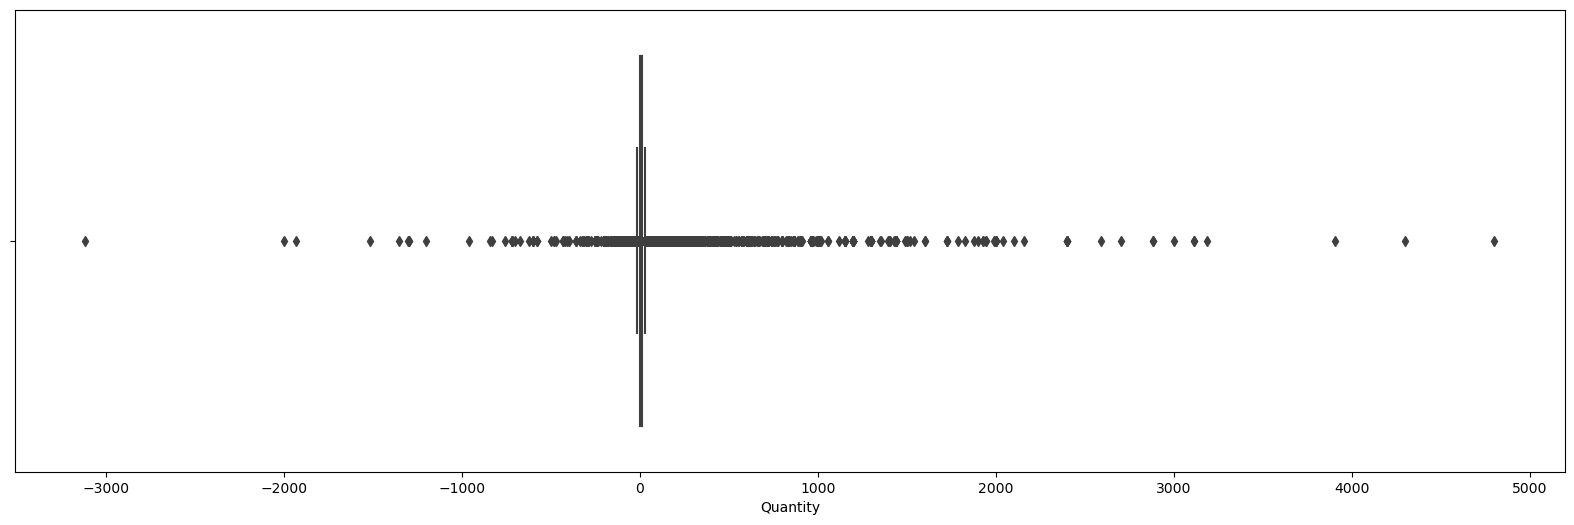

In [21]:
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x=data_retail["Quantity"])

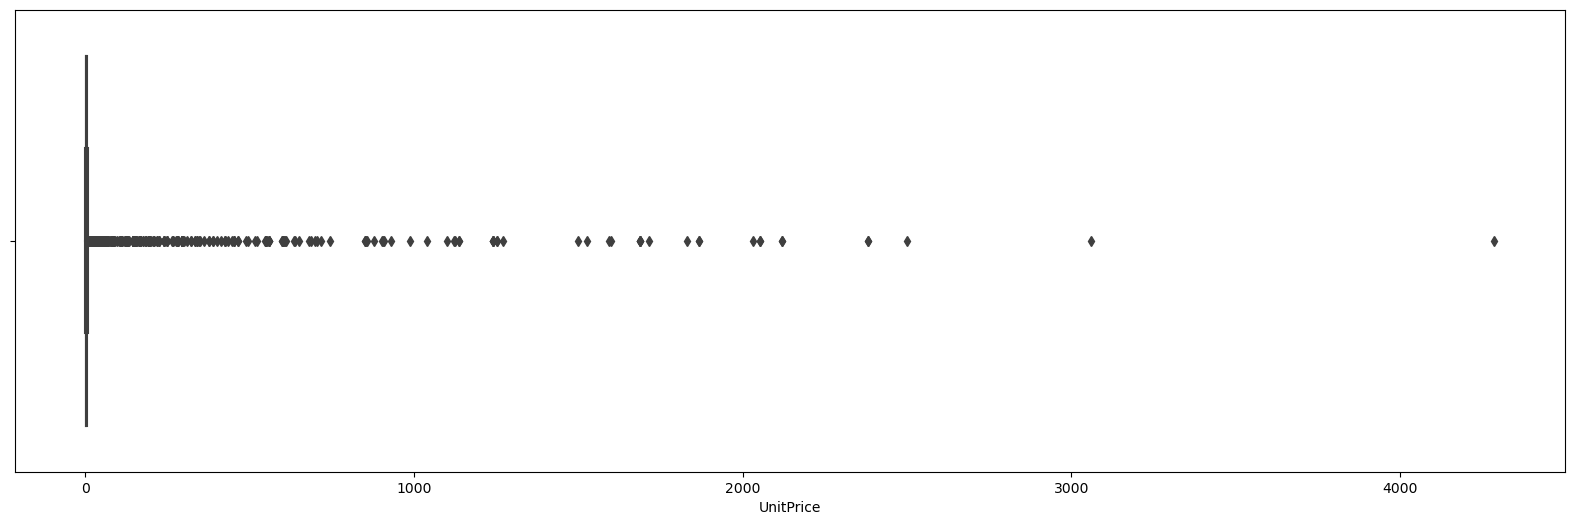

In [22]:
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x=data_retail["UnitPrice"])

### Key Metrics

To undertake machine learning, the initial step involves defining key metrics. Three crucial indicators—recency, frequency, and monetary value—are employed to analyse customer behaviour and identify customer groups with shared characteristics.


### Customer Segmentation
RFM stands for recency, frequency, and monetary value, three key indicators used to analyze customer behavior and identify groups of customers that share similar characteristics.

Understanding RFM analysis can help you get a pulse on your current customer engagement levels (recency), identify loyal and regular customers (frequency), and highlight high-value customers (monetary value). 
ith RFM, you can segment customers based on their purchasing patterns to help you predict future behavior, target your marketing efforts effectively, find your best customers, and increase customer retention. Customer loyalty is a critical factor that can make or break your business.

RFM analysis allows you to zoom out and look at the bigger picture of your customer base, helping you make informed decisions on how to allocate resources and prioritize your marketing strategies to improve customer engagement and retain customers.

Understanding recency, frequency, and monetary value will help you make informed decisions about how to optimize your marketing strategies, increase retention, identify your best customers, and ultimately drive business success.
#### 1) Monetary Value
Monetary value helps to highlight which customers are most valuable and generate the most revenue for your business. This number represents the total amount of money a specific person has spent on your company as a customer. 


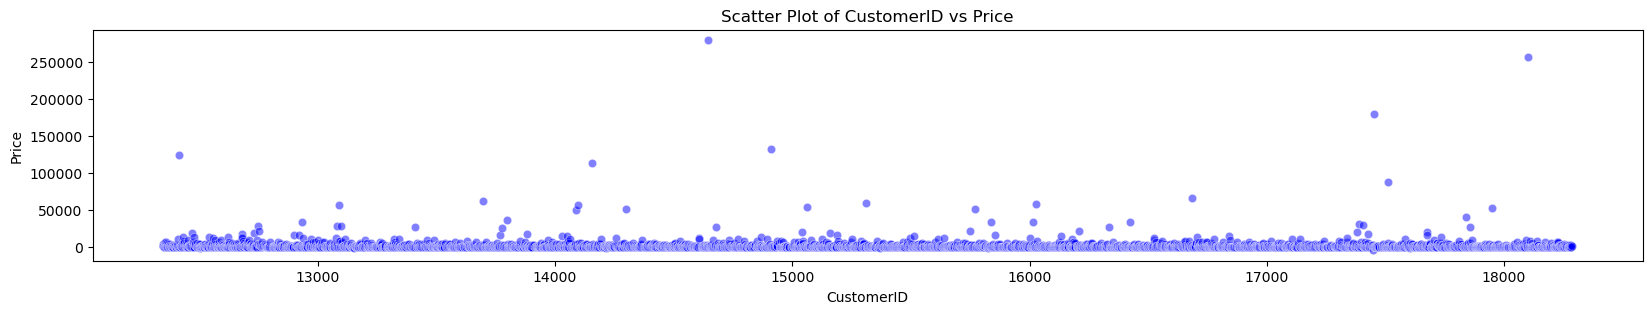

In [23]:
monetary_value = data_retail.groupby('CustomerID')['Price'].sum()
monetary_value=pd.DataFrame (data=monetary_value)
plt.figure(figsize=(20, 3))
sns.scatterplot(x=monetary_value.index, y=monetary_value["Price"], color='blue', alpha=0.5)
plt.title('Scatter Plot of CustomerID vs Price')
plt.xlabel('CustomerID')
plt.ylabel('Price')
plt.show()

#### 2)Frequency 

Frequency lets you see which customers are loyal and engage with your brand or company regularly by measuring how often customers interact with you within a specific period of time. 

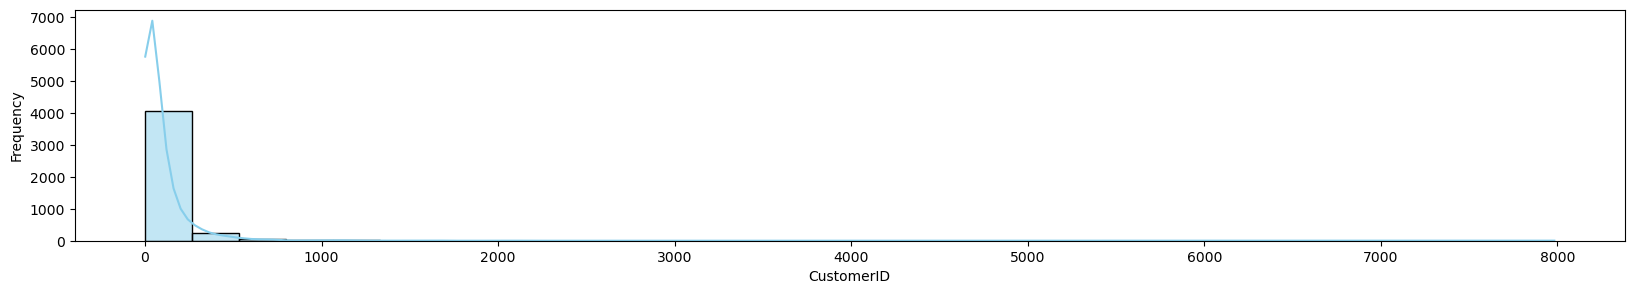

In [24]:
frequency = data_retail.groupby('CustomerID').size()
plt.figure(figsize=(20, 3))
sns.histplot(frequency, bins=30, kde=True, color='skyblue')
plt.xlabel('CustomerID')
plt.ylabel('Frequency')
plt.show()

#### 3) Recency 

Recency provides insights into current customer engagement levels by measuring how much time has passed since their last purchase.


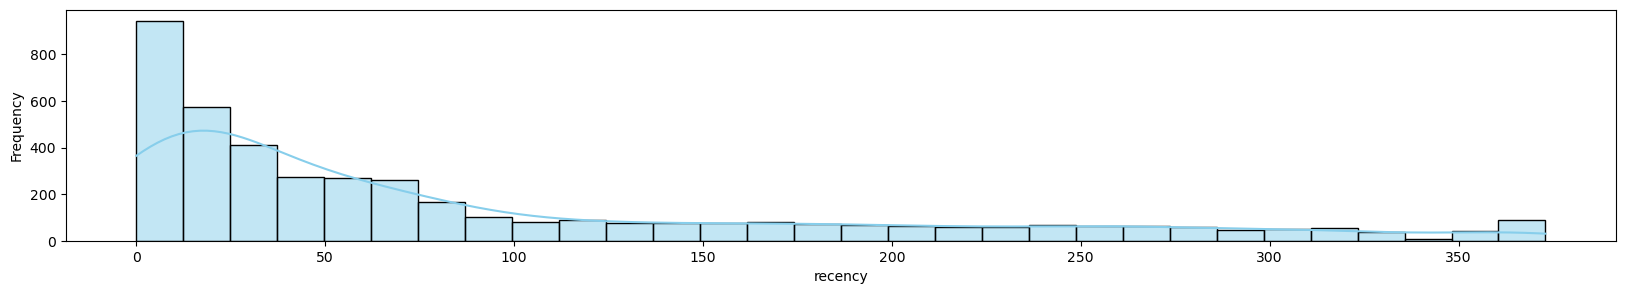

In [25]:
recency = data_retail.groupby('CustomerID')['InvoiceDate'].max()
recency = (last_date - recency).dt.days
plt.figure(figsize=(20, 3))
sns.histplot(recency, bins=30, kde=True, color='skyblue')
plt.xlabel('recency')
plt.ylabel('Frequency')
plt.show()

In [26]:
monetary_value["recency"] =recency.values
monetary_value["frequency"] =frequency.values
monetary_value.rename(columns={'Price': 'monetary_value'}, inplace=True)
data = monetary_value.copy()
data.describe()

,monetary_value,recency,frequency
count,4370.000000,4370.000000,4370.000000
mean,1899.343683,91.058352,93.091533
std,8195.267699,100.724742,232.514948
min,-4287.630000,0.000000,1.000000
25%,294.162500,16.000000,17.000000
50%,648.550000,49.000000,42.000000
75%,1611.995000,142.000000,102.000000
max,279489.020000,373.000000,7983.000000


In [27]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns , index=data.index)
scaled_df.describe()

,monetary_value,recency,frequency
count,4.370000e+03,4.370000e+03,4.370000e+03
mean,5.529441e-17,1.519253e-17,-2.585016e-18
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-7.550311e-01,-9.041351e-01,-3.961125e-01
25%,-1.958893e-01,-7.452681e-01,-3.272918e-01
50%,-1.526414e-01,-4.176051e-01,-2.197595e-01
75%,-3.506677e-02,5.058090e-01,3.831791e-02
max,3.387582e+01,2.799450e+00,3.393679e+01


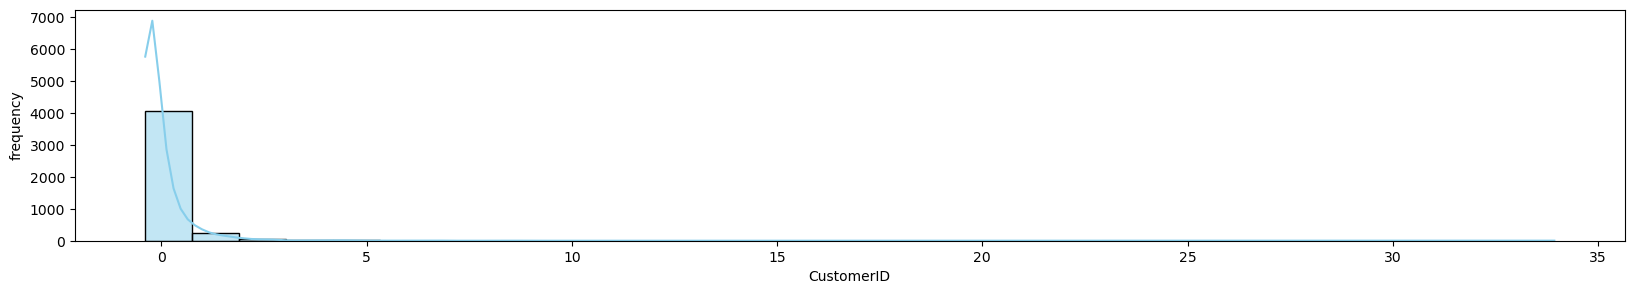

In [28]:
plt.figure(figsize=(20, 3))
sns.histplot(scaled_df["frequency"], bins=30, kde=True, color='skyblue')
plt.xlabel('CustomerID')
plt.ylabel('frequency')
plt.show()

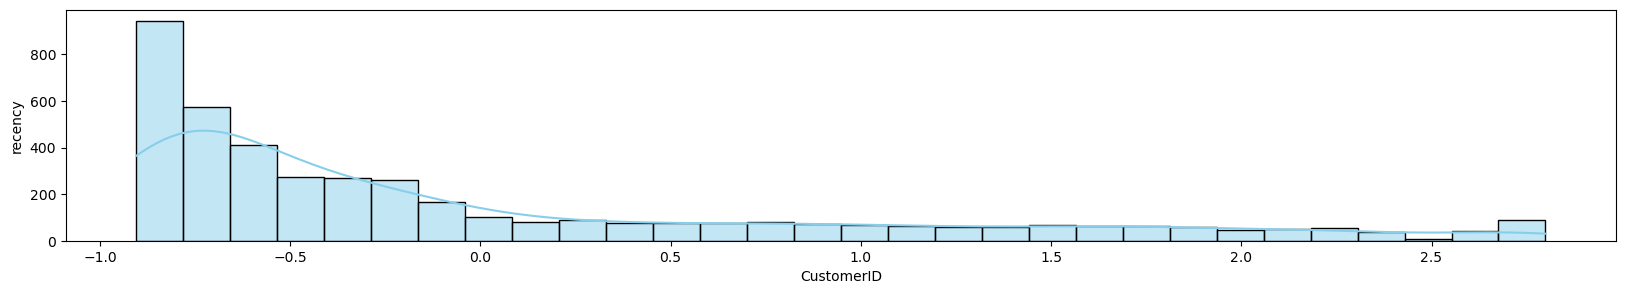

In [29]:
plt.figure(figsize=(20, 3))
sns.histplot(scaled_df["recency"], bins=30, kde=True, color='skyblue')
plt.xlabel('CustomerID')
plt.ylabel('recency')
plt.show()

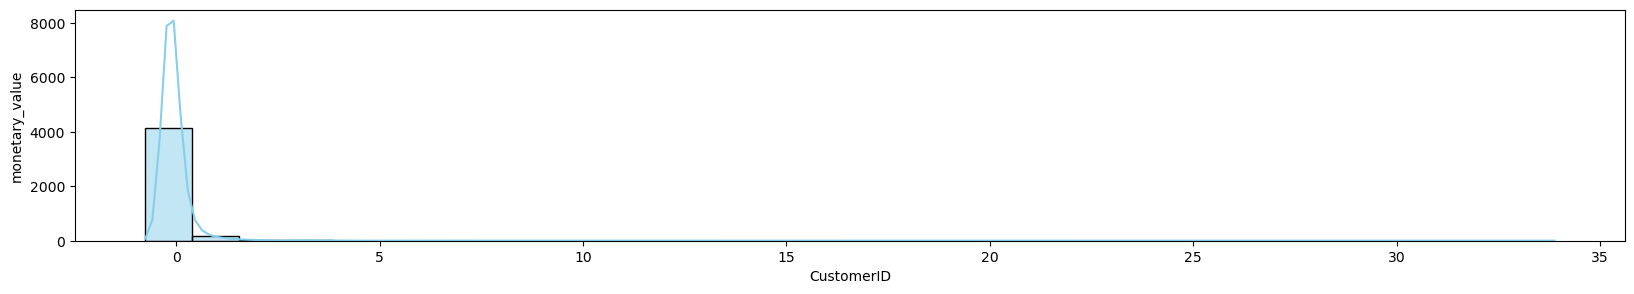

In [30]:
plt.figure(figsize=(20, 3))
sns.histplot(scaled_df["monetary_value"], bins=30, kde=True, color='skyblue')
plt.xlabel('CustomerID')
plt.ylabel('monetary_value')
plt.show()

In [31]:
columns_to_transform = ['monetary_value', 'recency', 'frequency']
scaled_df[columns_to_transform] = np.log1p(scaled_df[columns_to_transform])
print(scaled_df.head())

            monetary_value   recency  frequency
CustomerID                                     
12347.0           0.257882 -2.246261   0.323836
12348.0          -0.012539 -0.185577  -0.310710
12349.0          -0.017455 -1.292475  -0.090384
12350.0          -0.211930  1.151832  -0.396444
12352.0          -0.044153 -0.813314   0.008175


After establishing the key metrics—monetary value, recency, and frequency—their respective mean values of 1900.98, 91.06, and 93.08 reveal substantial differences in magnitudes. Neglecting to standardize these disparate scales can introduce bias, especially in machine learning algorithms sensitive to feature magnitudes, such as k-means clustering. Standardization becomes pivotal to ensuring each feature contributes proportionally to the analysis, avoiding dominance by those with larger scales. Moreover, it aids algorithm convergence by enhancing optimization speed during model training—a critical consideration for iterative optimization processes. Despite standardization, the data retains a skewed distribution. To address this, I applied logarithmic transformations, particularly effective for right-skewed distributions where data is concentrated on the left with a long tail to the right. This transformation compresses larger values, promoting a more symmetric distribution. The resulting 3D scatter plot, post-standardization and logarithmic transformation, is presented

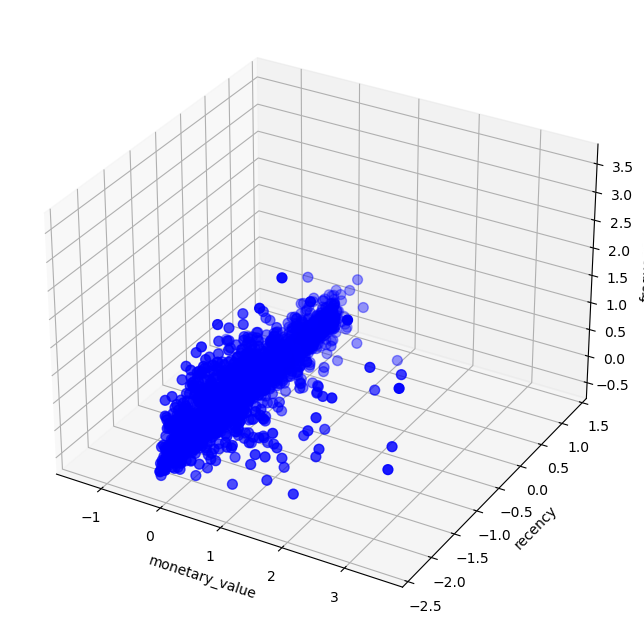

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_df['monetary_value'], scaled_df['recency'], scaled_df['frequency'], s=50, c='blue', marker='o')
ax.set_xlabel('monetary_value')
ax.set_ylabel('recency')
ax.set_zlabel('frequency')
plt.show()

To conduct clustering, both K-means clustering and Gaussian Mixture clustering were employed. The optimal number of clusters, determined through the elbow method, was found to be 3. Upon evaluation of the 3D scatter plot, it is evident that K-means clustering outperformed in effectively categorizing the clusters. The distinctiveness and clear separation of clusters in the plot provide visual confirmation of the efficacy of K-means clustering in this particular analysis.

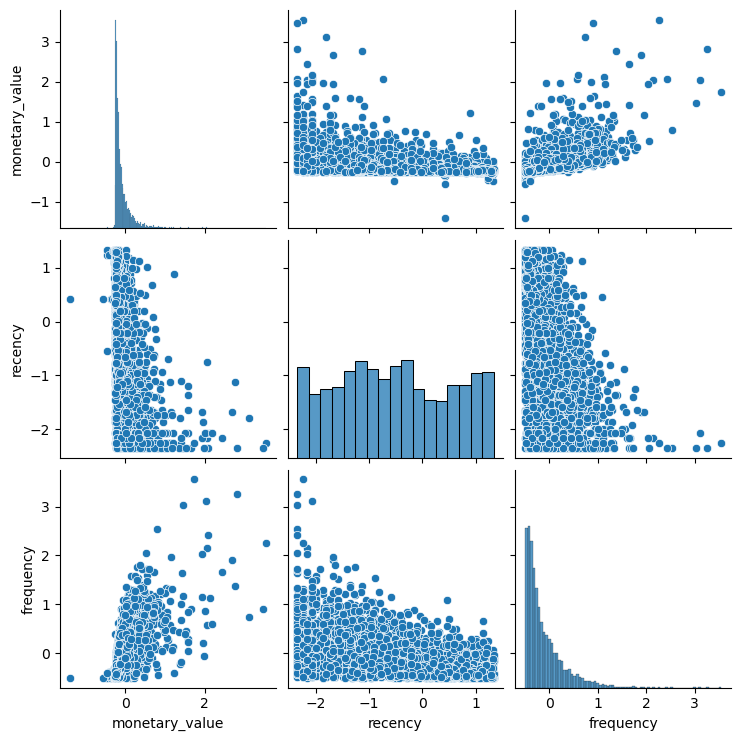

In [33]:
sns.pairplot(scaled_df)
plt.show()

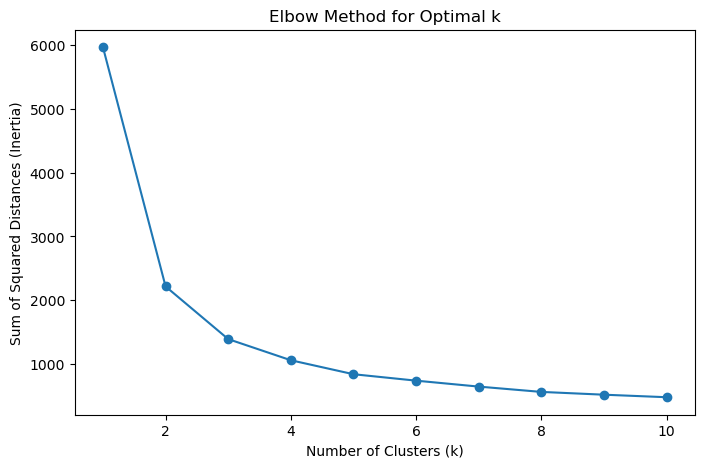

In [34]:
X = scaled_df[['monetary_value', 'recency', 'frequency']]
inertia_values = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.show()

In [35]:
scaled_df.head()
X = scaled_df[['monetary_value', 'recency', 'frequency']]
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df['cluster'] = kmeans.fit_predict(X)
print(scaled_df.head())

            monetary_value   recency  frequency  cluster
CustomerID                                              
12347.0           0.257882 -2.246261   0.323836        0
12348.0          -0.012539 -0.185577  -0.310710        2
12349.0          -0.017455 -1.292475  -0.090384        0
12350.0          -0.211930  1.151832  -0.396444        1
12352.0          -0.044153 -0.813314   0.008175        2


In [36]:
grouped_clusters = scaled_df.groupby('cluster')
cluster_stats = grouped_clusters.agg({'monetary_value': [ 'mean'],
    'recency': [ 'mean'],'frequency': ['mean']}).reset_index()
cluster_stats

,cluster,monetary_value,recency,frequency
,,mean,mean,mean
0,0,0.088198,-1.738501,0.162754
1,1,-0.188065,0.777064,-0.328509
2,2,-0.119993,-0.556793,-0.183887


The table is summarized the outcome of the K-means clustering . The presented table displays the mean values of the three features for each cluster, offering valuable insights for the company to tailor distinct marketing strategies. For instance, analysis of the table reveals that Cluster 0 is characterized by customers who make substantial transactions (highest monetary value), haven't made recent purchases (lowest recency), yet exhibit high engagement and loyalty through frequent transactions (highest frequency). This information can inform targeted marketing strategies aimed at retaining and maximizing the value from this customer segment.

In contrast, Cluster 1 appears to represent a segment of customers with different characteristics:
- They make smaller transactions (lowest monetary value).
- They have made recent purchases (highest recency).
- Their engagement with the business is less frequent (lowest frequency).

In [41]:
silhouette_avg = silhouette_score(X, scaled_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.34162624057127083


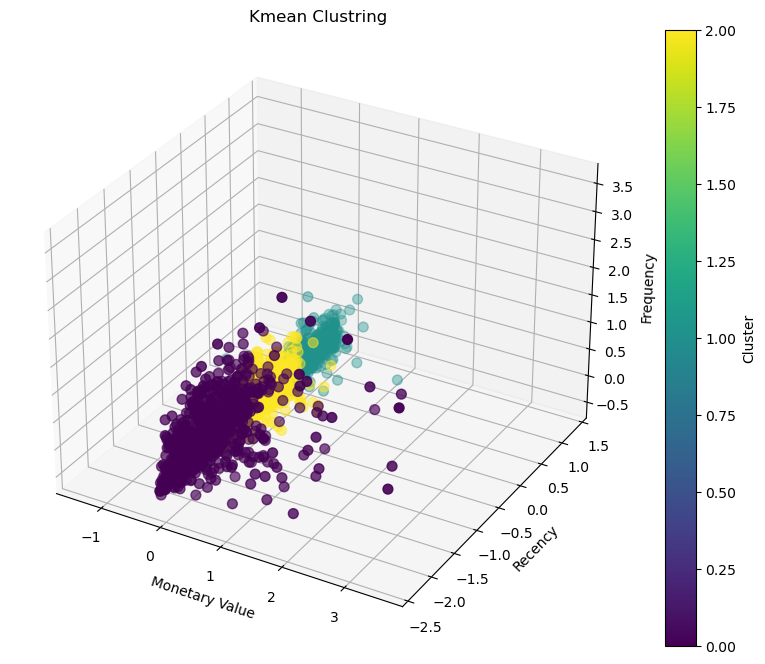

In [37]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(scaled_df['monetary_value'],scaled_df['recency'],scaled_df['frequency'],
    s=50,c=scaled_df['cluster'],cmap='viridis', marker='o')
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('Kmean Clustring')
plt.show()

In [38]:
n_components = 3  
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X)  
X["clusters"] = gmm.predict(X)
grouped_clusters = X.groupby('clusters')
cluster_stats = grouped_clusters.agg({'monetary_value': ['mean'],
    'recency': [ 'mean'],'frequency': [ 'mean']}).reset_index()
cluster_stats

,clusters,monetary_value,recency,frequency
,,mean,mean,mean
0,0,-0.217617,0.027203,-0.398120
1,1,-0.100425,-0.676542,-0.103620
2,2,0.381441,-1.450404,0.563914


In [42]:
silhouette_avg = silhouette_score(X, X["clusters"])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.30000273693709834


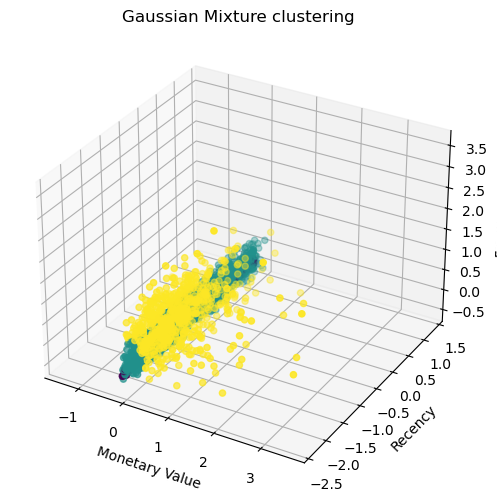

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['monetary_value'], X['recency'], X['frequency'], c=X["clusters"], cmap='viridis')
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Recency')
ax.set_zlabel('Frequency')
ax.set_title('Gaussian Mixture clustering ')
plt.show()

To assess the performance of clustering algorithms, I employed the Silhouette Score, a metric that gauges how similar an object is to its own cluster compared to others. A higher silhouette score signifies more well-defined clusters. The evaluation yielded a silhouette score of 0.34 for K-means clustering and 0.3 for Gaussian Mixture clustering. Consequently, the K-means clustering algorithm was selected, as it demonstrated a higher silhouette score, indicating better-defined clusters compared to the Gaussian Mixture clustering algorithm.



In summary, the clustering results provide actionable insights, allowing the company to implement more effective and targeted marketing strategies tailored to the specific needs and behaviors of different customer segments.